In [1]:
%matplotlib inline

In [2]:
import networkx as nx
import numpy as np

from matplotlib.patches import Polygon

import pandas as pd

import matplotlib.pyplot as plt

In [3]:
from colonists import (get_nodes, get_hex_paths, get_hexes,
                       assign_region_hex_indexes, shuffle_regions,
                       DEFAULT_MAP, plot_hexes)

In [7]:
df_nodes = get_nodes(8, 17, .165, 1.75)
df_hex_paths = get_hex_paths(df_nodes)

hex_count = df_hex_paths.hex.unique().max() + 1
df_hexes = get_hexes(hex_count, DEFAULT_MAP, port_offset=1)
assign_region_hex_indexes(df_hexes, inplace=True)

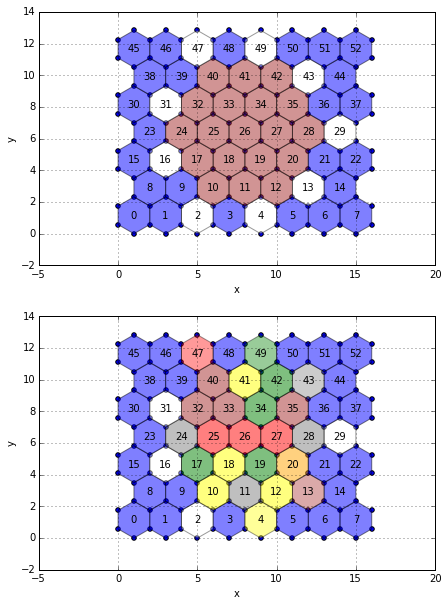

In [8]:
shuffle_regions(df_hexes, inplace=True)
fig, axes = plt.subplots(2, figsize=(8, 10))
plot_hexes(df_nodes, df_hexes, colorby='region', axis=axes[0])
plot_hexes(df_nodes, df_hexes, colorby='terrain', axis=axes[1])